# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [3]:
#!pip install finance-datareader

In [4]:
import FinanceDataReader as fdr

In [5]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [6]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-11-13,1149,1206,1134,1174,895540,NaN
1998-11-14,1195,1260,1195,1255,784260,0.068995
1998-11-16,1273,1302,1235,1295,1036810,0.031873
1998-11-17,1338,1338,1294,1297,924250,0.001544
1998-11-18,1296,1302,1266,1282,847000,-0.011565
...,...,...,...,...,...,...
2023-02-20,62900,63000,61800,62700,12908073,0.001597
2023-02-21,62700,62800,62000,62100,7665046,-0.009569
2023-02-22,61500,61800,61000,61100,11959088,-0.016103


In [7]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 1998-11-13 to 2023-02-24
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [8]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-02-20,62900,63000,61800,62700,12908073,0.001597
2023-02-21,62700,62800,62000,62100,7665046,-0.009569
2023-02-22,61500,61800,61000,61100,11959088,-0.016103
2023-02-23,61700,62500,61500,62000,13047099,0.014730
2023-02-24,62300,62600,61500,61600,8608767,-0.006452


**미국 주식 데이터**도 가져올 수 있습니다.

In [9]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [10]:
apple.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-16,153.509995,156.330002,153.350006,153.710007,153.710007,68167900
2023-02-17,152.350006,153.000000,150.850006,152.550003,152.550003,59095900
2023-02-21,150.199997,151.300003,148.410004,148.479996,148.479996,58867200
2023-02-22,148.869995,149.949997,147.160004,148.910004,148.910004,51011300
2023-02-23,150.089996,150.339996,147.240005,149.399994,149.399994,48349600


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [11]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [12]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.133329,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.102961,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.240784,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.544472,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.796764,134247600


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [13]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [14]:
ford.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,1.297609,1.328022,1.287471,1.287471,0.249645,2044376
1980-01-03,1.287471,1.287471,1.267196,1.287471,0.249645,2816257
1980-01-04,1.287471,1.287471,1.272265,1.277334,0.247679,3038203
1980-01-07,1.277334,1.287471,1.267196,1.267196,0.245714,2251526
1980-01-08,1.267196,1.292540,1.257059,1.292540,0.250628,4069022


In [15]:
ford.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-20,9.50,9.54,9.44,9.48,8.449280,50191200
2019-12-23,9.50,9.57,9.40,9.44,8.413630,54784400
2019-12-24,9.44,9.49,9.43,9.47,8.440370,11881600
2019-12-26,9.47,9.49,9.43,9.45,8.422543,28961300
2019-12-27,9.45,9.46,9.35,9.36,8.342328,28272800


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [16]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [17]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [18]:
stock = fdr.DataReader(STOCK_CODE)

In [19]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-11-13,1149,1206,1134,1174,895540,NaN
1998-11-14,1195,1260,1195,1255,784260,0.068995
1998-11-16,1273,1302,1235,1295,1036810,0.031873
1998-11-17,1338,1338,1294,1297,924250,0.001544
1998-11-18,1296,1302,1266,1282,847000,-0.011565


In [20]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-02-20,62900,63000,61800,62700,12908073,0.001597
2023-02-21,62700,62800,62000,62100,7665046,-0.009569
2023-02-22,61500,61800,61000,61100,11959088,-0.016103
2023-02-23,61700,62500,61500,62000,13047099,0.014730
2023-02-24,62300,62600,61500,61600,8631622,-0.006452


In [21]:
stock.index

DatetimeIndex(['1998-11-13', '1998-11-14', '1998-11-16', '1998-11-17',
               '1998-11-18', '1998-11-19', '1998-11-20', '1998-11-21',
               '1998-11-23', '1998-11-24',
               ...
               '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-17', '2023-02-20', '2023-02-21', '2023-02-22',
               '2023-02-23', '2023-02-24'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [22]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [23]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-11-13,1149,1206,1134,1174,895540,NaN,1998,11,13
1998-11-14,1195,1260,1195,1255,784260,0.068995,1998,11,14
1998-11-16,1273,1302,1235,1295,1036810,0.031873,1998,11,16
1998-11-17,1338,1338,1294,1297,924250,0.001544,1998,11,17
1998-11-18,1296,1302,1266,1282,847000,-0.011565,1998,11,18


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


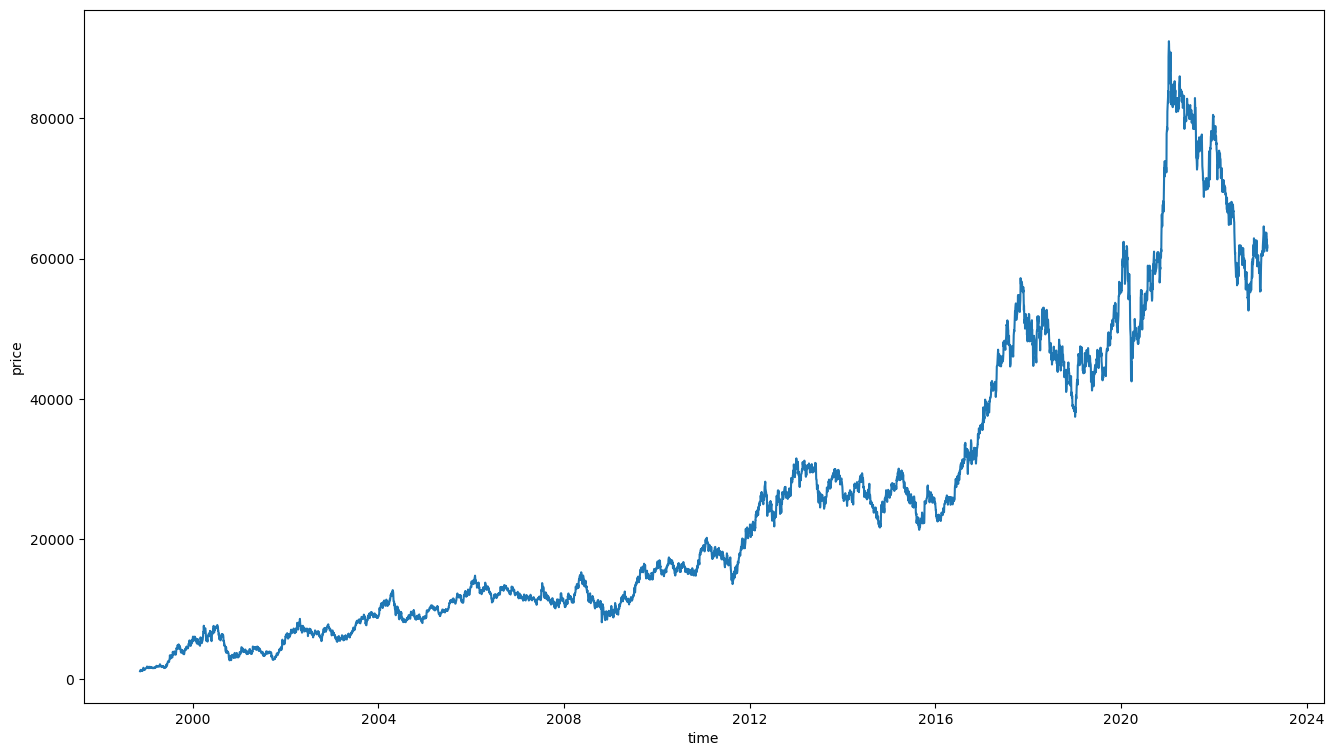

In [24]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

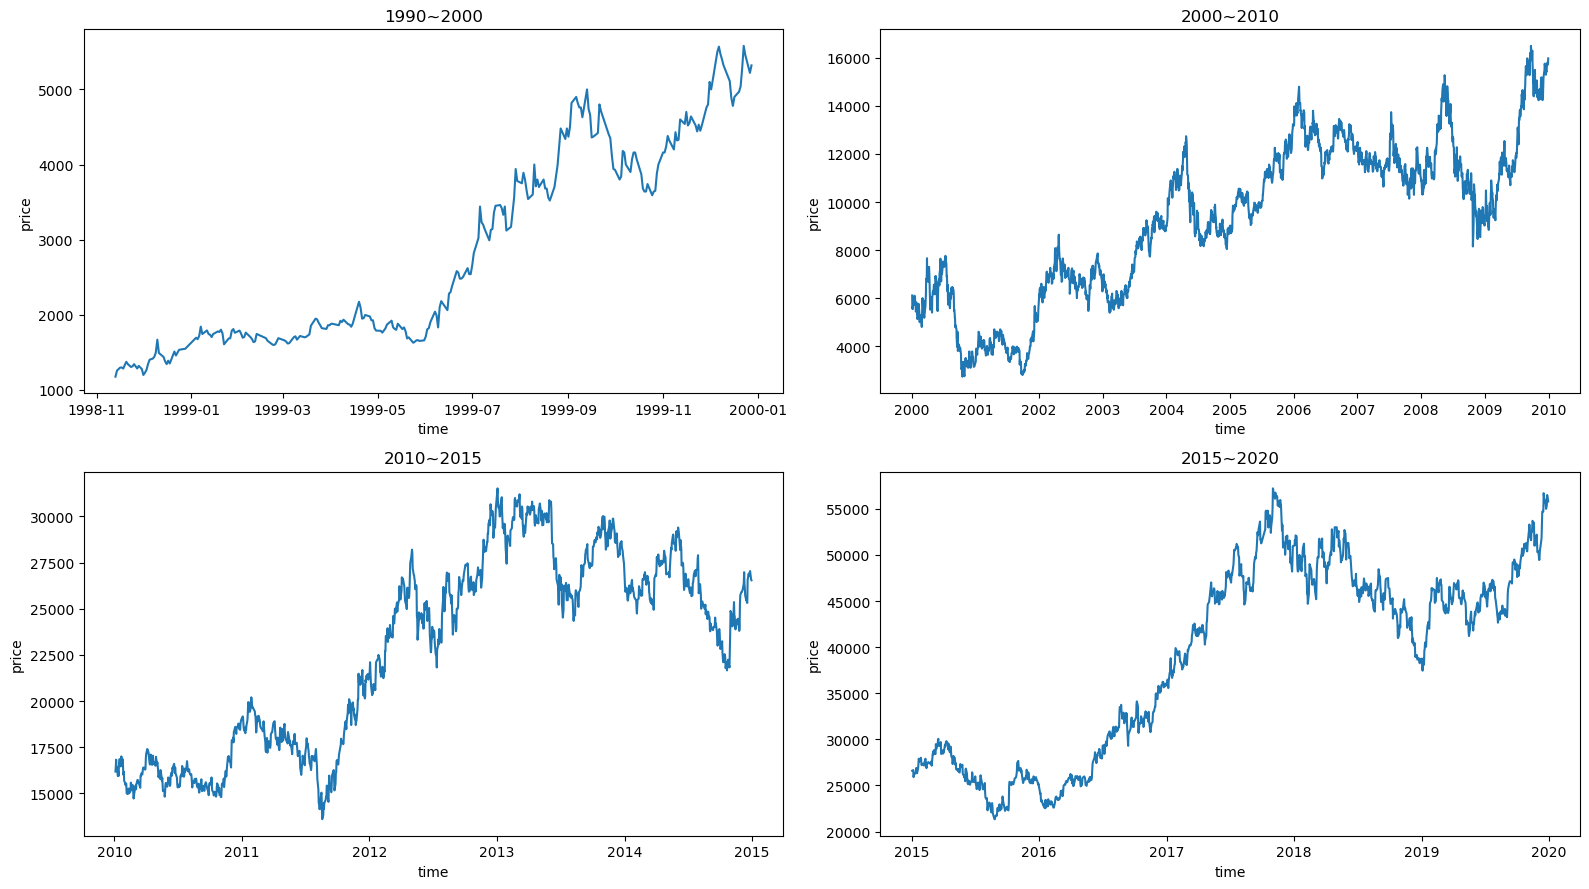

In [26]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.01272425, 0.01245868, 0.01267039, 0.        , 0.00991671],
       [0.01323367, 0.01301653, 0.01335196, 0.00090174, 0.00868446],
       [0.01409745, 0.01345041, 0.01379888, 0.00134705, 0.01148105],
       ...,
       [0.68106312, 0.63842975, 0.68156425, 0.66713424, 0.13242824],
       [0.68327796, 0.64566116, 0.68715084, 0.67715361, 0.14447626],
       [0.68992248, 0.64669421, 0.68715084, 0.67270055, 0.09558175]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [28]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [29]:
df

,Open,High,Low,Close,Volume
0,0.012724,0.012459,0.012670,0.000000,0.009917
1,0.013234,0.013017,0.013352,0.000902,0.008684
2,0.014097,0.013450,0.013799,0.001347,0.011481
3,0.014817,0.013822,0.014458,0.001369,0.010235
4,0.014352,0.013450,0.014145,0.001202,0.009379
...,...,...,...,...,...
5995,0.696567,0.650826,0.690503,0.684946,0.142937
5996,0.694352,0.648760,0.692737,0.678267,0.084878
5997,0.681063,0.638430,0.681564,0.667134,0.132428
5998,0.683278,0.645661,0.687151,0.677154,0.144476


## train / test 분할

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [32]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [33]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [34]:
x_train

,Open,High,Low,Volume
0,0.012724,0.012459,0.012670,0.009917
1,0.013234,0.013017,0.013352,0.008684
2,0.014097,0.013450,0.013799,0.011481
3,0.014817,0.013822,0.014458,0.010235
4,0.014352,0.013450,0.014145,0.009379
...,...,...,...,...
4795,0.531561,0.501860,0.529609,0.002776
4796,0.534441,0.510744,0.538547,0.002204
4797,0.537542,0.508471,0.536760,0.002433
4798,0.552602,0.515496,0.543017,0.002226


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [35]:
import tensorflow as tf

In [36]:
"""
    serise 텐서의 끝에 새로운 차원을 추가합니다.
    주어진 데이터셋을 윈도우로 분할합니다.
    윈도우의 마지막 원소가 예측하려는 값으로, window_size+1
    데이터셋을 윈도우 크기가 window_size+1의 배치로 변환하고,
    이러한 배치 데이터셋을 일렬로 연결하여 하나의 데이터셋을 생성합니다.

"""
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)  
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [37]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [38]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [39]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [41]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [42]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [43]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    143/Unknown - 6s 4ms/step - loss: 3.6507e-04 - mse: 7.3014e-04
Epoch 1: val_loss improved from inf to 0.00332, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 7s 10ms/step - loss: 3.5298e-04 - mse: 7.0596e-04 - val_loss: 0.0033 - val_mse: 0.0066
Epoch 2/50
148/150 [============================>.] - ETA: 0s - loss: 4.4218e-05 - mse: 8.8436e-05
Epoch 2: val_loss improved from 0.00332 to 0.00253, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 4ms/step - loss: 4.4645e-05 - mse: 8.9291e-05 - val_loss: 0.0025 - val_mse: 0.0051
Epoch 3/50
146/150 [============================>.] - ETA: 0s - loss: 4.1825e-05 - mse: 8.3649e-05
Epoch 3: val_loss improved from 0.00253 to 0.00248, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 3ms/step - loss: 4.2877e-05 - mse: 8.5753e-05 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 4/50
146/150 [============================>.] - ETA: 0s - loss: 

150/150 [==============================] - 0s 3ms/step - loss: 2.0250e-05 - mse: 4.0500e-05 - val_loss: 4.7529e-04 - val_mse: 9.5057e-04
Epoch 29/50
139/150 [==========================>...] - ETA: 0s - loss: 1.7622e-05 - mse: 3.5243e-05
Epoch 29: val_loss did not improve from 0.00038
150/150 [==============================] - 0s 3ms/step - loss: 2.0177e-05 - mse: 4.0354e-05 - val_loss: 5.3882e-04 - val_mse: 0.0011
Epoch 30/50
141/150 [===========================>..] - ETA: 0s - loss: 1.8815e-05 - mse: 3.7631e-05
Epoch 30: val_loss did not improve from 0.00038
150/150 [==============================] - 0s 3ms/step - loss: 1.9667e-05 - mse: 3.9333e-05 - val_loss: 7.3508e-04 - val_mse: 0.0015
Epoch 31/50
139/150 [==========================>...] - ETA: 0s - loss: 1.4902e-05 - mse: 2.9804e-05
Epoch 31: val_loss did not improve from 0.00038
150/150 [==============================] - 0s 3ms/step - loss: 1.6504e-05 - mse: 3.3009e-05 - val_loss: 7.9757e-04 - val_mse: 0.0016
Epoch 32/50
137/150 

저장한 ModelCheckpoint 를 로드합니다.

In [44]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [45]:
pred = model.predict(test_data)

37/37 [==============================] - 0s 3ms/step


In [46]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않습니다.

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

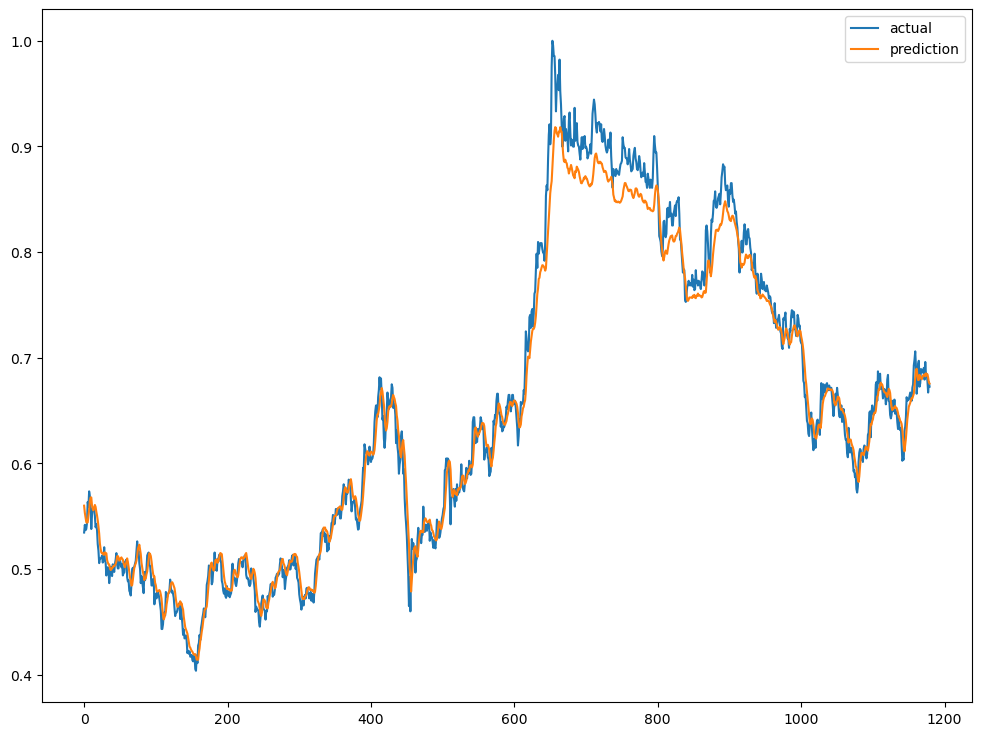

In [47]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 한계점
- 모델이 반영하는 피쳐가 오직 가격 뿐으로 거의 이전날의 가격과 비슷할 것으로 예측하게 되어 예측력이 부족하다.
- 더 많은 피쳐들을 반영하여 모델을 학습하거나 주식을 매수/매도 할지 결정하는 식으로 모델을 설계해야 할 것 같다.
- 데이터가 stationary 하지 않기 때문에 주가의 변동률을 가지고 모델링을 진행하는 방안도 고려해보자.